## Hack 3: “Using SKOS to display OWL ontologies”

AgroHackathon, LIRMM, Montpellier, 1 July 2016

* Tom Baker
* Caterina Caracciolo
* Simon Jupp
* Marie-Angelique Laporte
* Isabelle Mougenot
* Stella Zevio

#### Problem

Make OWL ontologies browsable with simple hierarchical interfaces such as the
[Skosmos browser](http://browser.agrisemantics.org/gacs/en/) for GACS.

#### Use cases

1. People who want to tag or annotate their resources with terms from OWL ontologies (e.g., URIs or labels of OWL classes).
2. People who want to browse the terms of OWL ontologies and for whom the relations broader, narrower, and related are sufficient.


#### Hack proposal

*  Specify heuristics for the lossy translation of an example OWL ontology into SKOS
*  Implement a simple conversion based on the heuristics, e.g., in SPARQL.
*  Load the SKOS translation of the ontology into a SKOS visualizer.

#### Requirement 1

SKOS browser must show subproperties of skos:broader.  Example:

    agro:isPartOf
        rdfs:subPropertyOf skos:broader .

should be displayed as a hierarchy

    skos:LivingOrganism
      agro:Plant
        agro:Leaf

...where leaf is "part of" (a subproperty of broader).

#### Requirement 2

Example:

    agro:Cow
      agro:eats  agro:Plant .

If agro:eats is a subproperty of skos:related, this means that Cow is somehow related to Plant.  However, this should not be part of the display hierarchy.

#### Simon Jupp's converter, OBO to SKOS

* Available at http://mowl-power.cs.man.ac.uk:8080/obotoskos
* See heuristics at http://www.cs.man.ac.uk/~sjupp/skos/index.html
  * For example OBO Name ("The preferred term name") is converted into skos:prefLabel
* Note: * https://github.com/ontodev/robot can convert between ontology formats.  The default format is RDF/XML, but Robot also supports the OBO file format.

```
robot convert --input annotated.owl --output results/annotated.obo
```

#### Example in OBO (before conversion)

```
[Term]
id: CL:0000097
name: mast cell
def: "A cell that is found in almost all tissues containing numerous basophilic granules and capable of releasing large amounts of histamine and
heparin upon activation." [GOC:add, ISBN:068340007X, MESH:A.11.329.427]
related_synonym: "tissue basophil" [ISBN:068340007X]
exact_synonym: "labrocyte" [ISBN:0721601464]
exact_synonym: "mastocyte" [ISBN:0721601464]
is_a: CL:0000766 ! myeloid leukocyte
relationship: develops_from CL:0000831 ! mast cell progenitor
```

#### Example in SKOS (after conversion)

```
:CL_0000097
    :develops_from :CL_0000831 ;
    :is-a :CL_0000766 ;
    :super-class-of :CL_0000484, :CL_0000485 ;
    a skos:Concept ;
    skos:altLabel "\"labrocyte\" [ISBN:0721601464]"@en, ...
    skos:definition "\"A cell that is found in almost all tissues containing ... 
    skos:notation "CL:0000097"^^xsd:string ;
    skos:prefLabel "mast cell"@en .
```

#### Skosify

* See https://github.com/NatLibFi/Skosify/wiki/OWL-conversion-to-SKOS
* National Library of Finland routinely converts OWL into SKOS.  The Finnish Upper Level Ontology YSO and its many domain specific extensions are maintained as OWL ontologies (though nowadays most of the properties are from SKOS) and translated to SKOS using Skosify as part of the publication process. Skosify can use a mapping file to convert e.g. owl:Class into skos:Concept and rdfs:label into skos:prefLabel.
* Uses configuration file to specify OWL-to-SKOS mappings, e.g., https://github.com/NatLibFi/Skosify/blob/master/owl2skos.cfg :

````
[types]
owl.Class=skos:Concept
rdfs.Class=skos:Concept

[literals]
rdfs.label=skos:prefLabel
rdfs.comment=skos:definition

[relations]
rdfs.subClassOf=skos:broader
owl.equivalentClass=skos:exactMatch
````

### Converting an example ontology

#### Simple ontology (starting point)

````
agro:Plant  a             owl:Class ;
        rdfs:subClassOf   agro:LivingOrganism ;
        owl:disjointWith  agro:Animal .

agro:Animal  a           owl:Class ;
        rdfs:subClassOf  agro:LivingOrganism .

agro:p1  a          agro:Plant ;
        rdfs:label  "plant1"^^xsd:string ;
        agro:name   "Platanus wrighitii"^^xsd:string .

agro:LivingOrganism  a  owl:Class .

agro:name  a         owl:DatatypeProperty ;
        rdfs:domain  agro:LivingOrganism ;
        rdfs:range   xsd:string .
````

#### SPARQL Query

````
CONSTRUCT {
            ?s rdf:type skos:Concept .
            ?s skos:broader ?subC .
            ?s skos:prefLabel ?label .
          }
WHERE { 
        ?s rdf:type owl:Class  .
        OPTIONAL { ?s rdfs:subClassOf ?subC . }
        OPTIONAL { ?s rdfs:label ?label . }
      }
````

#### Query result (SKOS)

````
agro:Plant  a           skos:Concept ;
        skos:broader    agro:LivingOrganism ;
        skos:prefLabel  "Planta"@it , "Plante"@fr , "Plant"@en .

agro:Animal  a          skos:Concept ;
        skos:broader    agro:LivingOrganism ;
        skos:prefLabel  "Animale"@it , "Animal"@fr , "Animal"@en .

agro:LivingOrganism  a  skos:Concept ;
        skos:prefLabel  "Organismo Vivente"@it , "Organisme Vivant"@fr , "Living Organism"@en .
````

#### Query 

````
CONSTRUCT {
            ?s rdf:type skos:Concept .
            ?s skos:broader ?subC .
            ?s skos:prefLabel ?label .
            ?p rdfs:subPropertyOf skos:broader .
            ?s ?p ?o .
            ?p2 rdfs:subPropertyOf skos:related .
            ?s ?p2 ?oRel .
          }
WHERE { 
        ?s rdf:type owl:Class  .
        OPTIONAL { ?s rdfs:subClassOf ?subC . }
        OPTIONAL { ?s rdfs:label ?label . }
        OPTIONAL { ?p rdf:type owl:TransitiveProperty .
                   ?s ?p ?o .
                 }
        OPTIONAL {
                   ?p2 rdf:type owl:ObjectProperty .
                   FILTER NOT EXISTS { ?p2 rdf:type owl:TransitiveProperty } .
                   ?s ?p2 ?oRel .
                  }
      }
````

#### Result

````
agro:eats  rdfs:subPropertyOf  skos:related .

agro:Leaf  a           skos:Concept ;
        agro:isPartOf  agro:Plant .

agro:Plant  a           skos:Concept ;
        skos:broader    agro:LivingOrganism ;
        skos:prefLabel  "Planta"@it , "Plante"@fr , "Plant"@en .

agro:Animal  a          skos:Concept ;
        skos:broader    agro:LivingOrganism ;
        skos:prefLabel  "Animale"@it , "Animal"@fr , "Animal"@en .

agro:LivingOrganism  a  skos:Concept ;
        skos:prefLabel  "Organismo Vivente"@it , "Organisme Vivant"@fr , "Living Organism"@en .

agro:isPartOf  rdfs:subPropertyOf  skos:broader .

agro:Cow  a        skos:Concept ;
        agro:eats  agro:Plant .
````

In [2]:
%%script bash
arq --data agro.n3 '
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX dc: <http://purl.org/dc/terms/> 
PREFIX owl: <http://www.w3.org/2002/07/owl#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX agro:  <http://www.sw.fr/isa/agro#> 

CONSTRUCT {
            ?s rdf:type skos:Concept .
            ?s skos:broader ?subC .
            ?s skos:prefLabel ?label .
            ?p rdfs:subPropertyOf skos:broader .
            ?s ?p ?o .
            ?p2 rdfs:subPropertyOf skos:related .
            ?s ?p2 ?oRel .
            ?restrictionP rdfs:subPropertyOf skos:related .
            ?s ?restrictionP ?restrictionC .
          }
WHERE { 
        ?s rdf:type owl:Class  .
        OPTIONAL { ?s rdfs:subClassOf ?subC . 
                   FILTER (!isBlank(?subC)) .
                 }
        OPTIONAL { ?s rdfs:label ?label . }
        OPTIONAL {
                   ?x rdf:type owl:Restriction .
                   ?x owl:onProperty ?restrictionP .
                   ?x owl:someValuesFrom|owl:allValuesFrom ?restrictionC .
                   ?s rdfs:subClassOf|owl:equivalentClass ?x .
                 }
        OPTIONAL { ?p rdf:type owl:TransitiveProperty .
                   ?s ?p ?o .
                 }
        OPTIONAL {
                   ?p2 rdf:type owl:ObjectProperty .
                   FILTER NOT EXISTS { ?p2 rdf:type owl:TransitiveProperty } .
                   ?s ?p2 ?oRel .
                  }
    }
'

@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix agro:  <http://www.sw.fr/isa/agro#> .
@prefix dc:    <http://purl.org/dc/terms/> .

agro:eats  rdfs:subPropertyOf  skos:related .

agro:Leaf  a           skos:Concept ;
        agro:isPartOf  agro:Plant .

agro:Plant  a           skos:Concept ;
        skos:broader    agro:LivingOrganism ;
        skos:prefLabel  "Planta"@it , "Plante"@fr , "Plant"@en .

agro:Animal  a          skos:Concept ;
        skos:broader    agro:LivingOrganism ;
        skos:prefLabel  "Animale"@it , "Animal"@fr , "Animal"@en .

agro:Herbivore  a     skos:Concept ;
        agro:eats     agro:Plant ;
        skos:broader  agro:Animal .

agro:LivingOrganism  a  skos:Concept ;
        skos:prefLabel  "Organismo Vivente"@it , "Organ

In [2]:
%%script bash
arq --data agro.n3 '
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX dc: <http://purl.org/dc/terms/> 
PREFIX owl: <http://www.w3.org/2002/07/owl#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX agro:  <http://www.sw.fr/isa/agro#> 
        
CONSTRUCT { 
  ?cs rdf:type skos:ConceptScheme . 
  ?s rdf:type skos:Concept . 
  ?s skos:inScheme ?cs. 
  ?s skos:broader ?subC . 
  ?s skos:prefLabel ?label . 
  ?s skos:definition ?def . 
  ?p rdfs:subPropertyOf skos:broader . 
  ?s ?p ?o . 
  ?p2 rdfs:subPropertyOf skos:related . 
  ?s ?p2 ?oRel . 
  ?restrictionP rdfs:subPropertyOf skos:related . 
  ?s ?restrictionP ?restrictionC . 
  ?s skos:related ?itemSimple . 
  ?itemP rdfs:subPropertyOf skos:related . 
  ?s ?itemP ?itemC . 
  ?s ?DCPropS ?propertiesValS . 
  ?cs ?DCProp ?propertiesVal . 
  ?propAnn rdfs:subPropertyOf skos:note . 
  ?s ?propAnn ?annVal . 
  ?dataProp rdfs:subPropertyOf skos:note . 
  ?s ?dataProp ?dataVal . 
}
WHERE { 
          ?s rdf:type owl:Class . 
          FILTER (!isBlank(?s))
          OPTIONAL { 
            ?s rdfs:subClassOf ?subC . 
            FILTER (!isBlank(?subC)) 
     }
      OPTIONAL { 
          ?s rdfs:label ?label .
     }
      OPTIONAL { 
      ?s rdfs:comment ?def .
     }
      OPTIONAL { 
      ?cs rdf:type owl:Ontology .
     }
      OPTIONAL { 
      ?cs ?DCProp ?propertiesVal . 
      FILTER (STRSTARTS(STR(?DCProp), "http://purl.org/dc/terms")) 
     }
      OPTIONAL { 
      ?s ?DCPropS ?propertiesValS . 
      FILTER (STRSTARTS(STR(?DCPropS), "http://purl.org/dc/terms")) 
     }
      OPTIONAL { 
      ?s ?propAnn ?annVal . 
      ?propAnn rdf:type owl:AnnotationProperty . 
     }
      OPTIONAL { 
      ?s ?dataProp ?dataVal . 
      ?dataProp rdf:type owl:DatatypeProperty . 
     }
      OPTIONAL { 
      ?x rdf:type owl:Restriction . 
      ?x owl:onProperty ?restrictionP . 
      ?x owl:someValuesFrom|owl:allValuesFrom ?restrictionC . 
      ?s rdfs:subClassOf|owl:equivalentClass ?x . 
     }
      OPTIONAL { 
      {?s owl:equivalentClass ?intersertion . 
      ?intersertion owl:intersectionOf|owl:unionOf ?list .
      ?list rdf:rest*/rdf:first ?item . 
      ?item rdf:type owl:Class . 
      BIND (?item as ?itemSimple) . 
     } UNION {
      ?item owl:onProperty ?itemP . 
      ?item owl:someValuesFrom|owl:allValuesFrom ?itemC . 
     }
     }
      OPTIONAL { 
          ?p rdf:type owl:TransitiveProperty . 
          ?s ?p ?o . 
     }
      OPTIONAL { 
      ?p2 rdf:type owl:ObjectProperty . 
     FILTER NOT EXISTS { ?p2 rdf:type owl:TransitiveProperty } . 
      ?s ?p2 ?oRel . 
    }
 }'

@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix agro:  <http://www.sw.fr/isa/agro#> .
@prefix dc:    <http://purl.org/dc/terms/> .

agro:Omnivore  a       skos:Concept ;
        agro:eats      agro:Plant , agro:Animal ;
        skos:inScheme  agro: ;
        skos:related   agro:Animal .

agro:eats  rdfs:subPropertyOf  skos:related .

agro:Plant  a           skos:Concept ;
        agro:eats       agro:Plant , agro:Animal ;
        skos:broader    agro:LivingOrganism ;
        skos:inScheme   agro: ;
        skos:prefLabel  "Planta"@it , "Plante"@fr , "Plant"@en .

agro:Leaf  a           skos:Concept ;
        agro:eats      agro:Plant , agro:Animal ;
        agro:isPartOf  agro:Plant ;
        skos:inScheme  agro: .

agro:Animal  a          skos:Concep

#### Requirement 1

SKOS browser must show subproperties of skos:broader.  Example:

    agro:isPartOf
        rdfs:subPropertyOf skos:broader .

should be displayed as a hierarchy

    skos:LivingOrganism
      agro:Plant
        agro:Leaf

...where leaf is "part of" (a subproperty of broader).

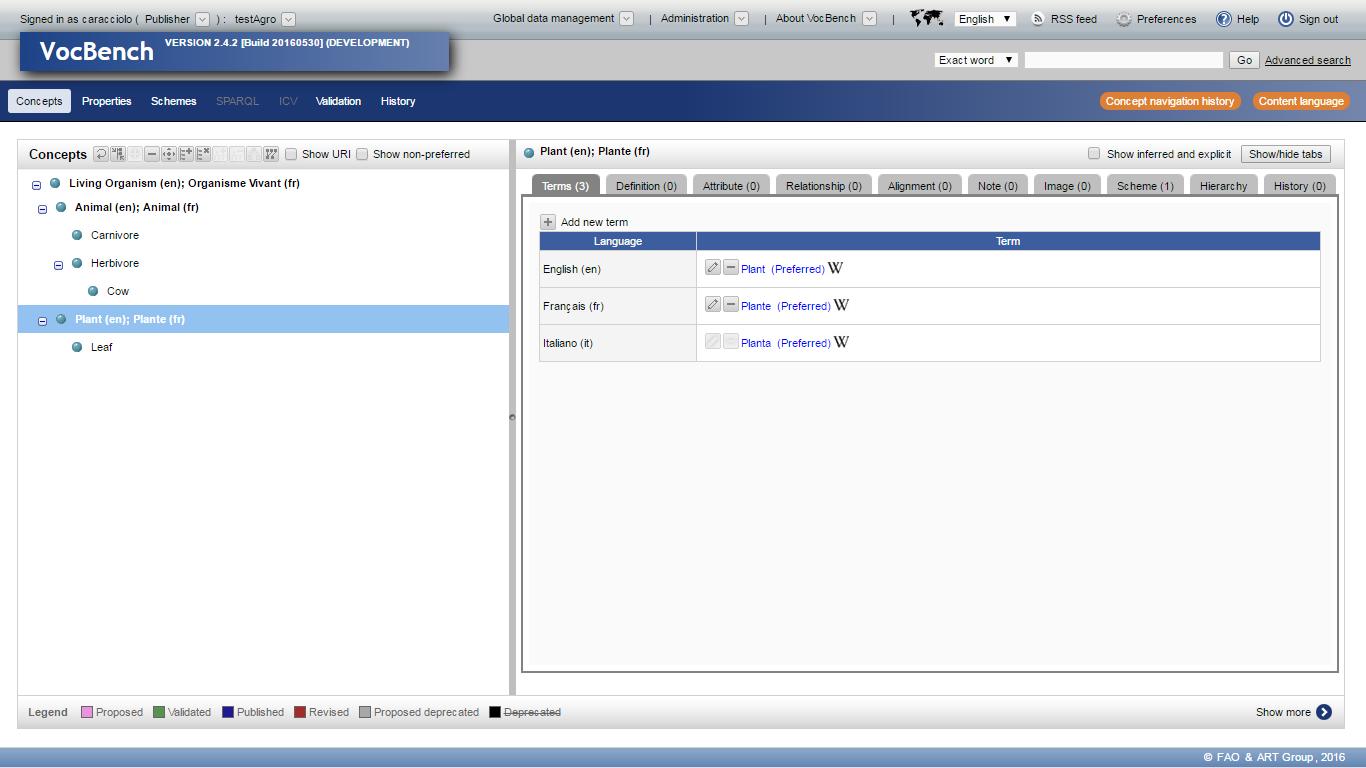

In [1]:
from IPython.display import Image
Image(filename='vocbench.png')

#### Requirement 2

Example:

    agro:Cow
      agro:eats  agro:Plant .

If agro:eats is a subproperty of skos:related, this means that Cow is somehow related to Plant.  However, this should not be part of the display hierarchy.